In [2]:
from mdagent import MDAgent
import os 
import mdtraj as md

In [3]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(parent_dir)
from robustness_prompts import get_prompt

prompt_9_descriptive = get_prompt("descriptive", 9)
prompt_9_natural = get_prompt("natural", 9)

prompt_9_descriptive, prompt_9_natural

('Complete all of the following tasks: 1. Download the PDB file 1LYZ. 2. Report the secondary structure assignments of the downloaded PDB structure. 3. Find any known binding or active sites. 4. Simulate for 1ps at 300 K. 5. Compute the RMSD. 6. Compute the radius of gyration over time. 7. Compute the SASA (solvent accessible surface area). 8. Simulate for 1ps at 400K. 9. Compute the RMSD of the 400K simulation.',
 'Simulate 1LYZ for 1ps at 300 K and for 1ps at 400K. Report the secondary structure assignments of the downloaded PDB structure and any known binding or active sites. Compute SASA and radius of gyration of the 300K simulation. Compute RMSD of both simulations.')

In [4]:
llm_model = "claude-3-5-sonnet-20240620"
tools = "all"

In [5]:
agent_1 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_1.run(prompt_9_descriptive)

Thought: To complete all these tasks, I'll need to use multiple tools in sequence. Let's start with downloading the PDB file for 1LYZ.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```PDB file found with this ID: 1LYZ
Thought: Great, we've successfully downloaded the PDB file for 1LYZ. Now, let's move on to the next task, which is to report the secondary structure assignments of the downloaded PDB structure.

Action:
```
{
    "action": "ComputeDSSP",
    "action_input": {
        "traj_file": "1LYZ_191318",
        "top_file": "1LYZ_191318",
        "target_frames": "first"
    }
}
```Thought: We've successfully obtained the secondary structure assignments for 1LYZ. Now, let's move on to finding any known binding or active sites for this protein. We'll use the GetAllKnownSites tool, but first, we need to get the UniProt ID for 1LYZ.

Action:
```
{
    "action": "MapProteinRepresentation",
    "action_input": {
        "query": "1LYZ",
        "src_db":

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [6]:
registry_1 = agent_1.path_registry
print(registry_1.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_191318: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_191318
 rec0_191321: dssp values for trajectory with id: 1LYZ_191318
 rec0_191350: dssp values for trajectory with id: 1LYZ_191318
 1LYZ_191506: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_191532: Initial positions for simulation sim0_191532
 sim0_191532: Basic Simulation of Protein 1LYZ_191506
 rec0_191533: Simulation trajectory for protein 1LYZ_191506 and simulation sim0_191532
 rec1_191533: Simulation state log for protein 1LYZ_191506 and simulation sim0_191532
 rec2_191533: Simulation pdb frames for protein 1LYZ_191506 and simulation sim0_191532
 rmsd_1LYZ: RMSD for 1LYZ
 fig0_191621: RMSD plot for 1LYZ
 rgy_rec0_191533: Radii of gyration per frame for rec0_191533
 fig0_191646: Plot of radii of gyration over time for rec0_191533
 sasa_1LYZ: Total SASA values for 1L

In [9]:
# make sure pdb was downloaded
assert os.path.exists(registry_1.get_mapped_path("1LYZ_191318"))

In [10]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_1)
dssp._run(traj_file= "1LYZ_191318", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [11]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P00698")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}, {'start': 70, 'start_modifier': 'EXACT', 'end': 70, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nBinding Sites: [{'start': 119, 'start_modifier': 'EXACT', 'end': 119, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nNo other relevant sites."

In [12]:
# make sure trajectory and topology exist (sim1)
traj_path_1_1 = registry_1.get_mapped_path("rec0_191533")
top_path_1_1 = registry_1.get_mapped_path("top_sim0_191532")

assert os.path.exists(traj_path_1_1)
assert os.path.exists(top_path_1_1)

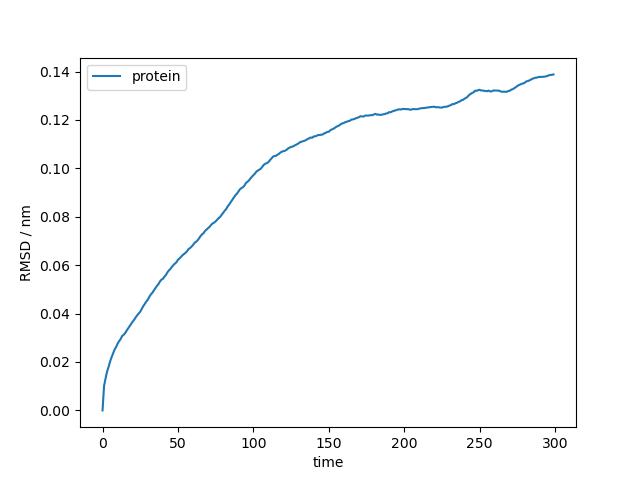

In [13]:
# make sure rmsd plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_191621'))

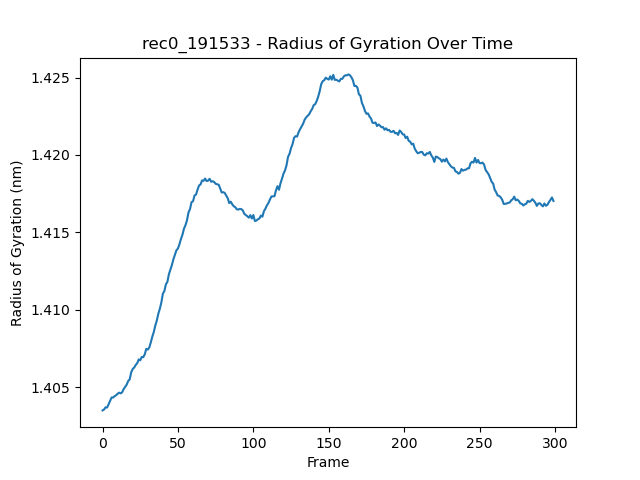

In [14]:
# make sure rgy plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_191646'))

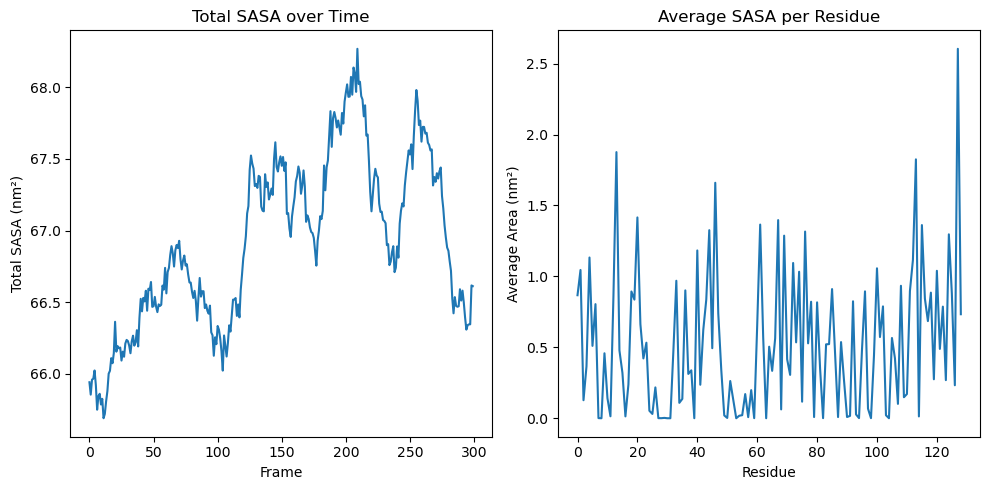

In [15]:
# make sure sasa plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_191809'))

In [16]:
# make sure trajectory and topology exist (sim2)
traj_path_1_2 = registry_1.get_mapped_path("rec0_191837")
top_path_1_2 = registry_1.get_mapped_path("top_sim0_191837")

assert os.path.exists(traj_path_1_2)
assert os.path.exists(top_path_1_2)

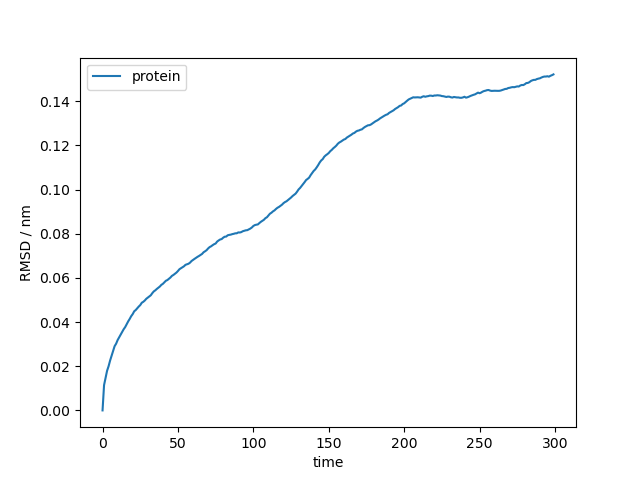

In [17]:
# make sure rmsd plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_191949'))

In [5]:
agent_2 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_2.run(prompt_9_natural)

Thought: To address this complex task, I'll need to break it down into several steps. Let's start by downloading the PDB file for 1LYZ, then run the simulations, analyze the secondary structure, find binding and active sites, and finally compute the requested metrics.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```PDB file found with this ID: 1LYZ
Thought: Great, we have successfully downloaded the PDB file for 1LYZ. Now, let's proceed with the simulations. We'll start by setting up and running the simulation at 300K for 1ps.

Action:
```
{
    "action": "SetUpandRunFunction",
    "action_input": {
        "pdb_id": "1LYZ_193010",
        "forcefield_files": ["amber14-all.xml", "amber14/tip3pfb.xml"],
        "save": true,
        "system_params": {
            "nonbondedMethod": "PME",
            "nonbondedCutoff": "1 * nanometers",
            "constraints": "HBonds",
            "rigidWater": true,
            "ewaldErrorTolerance": 0.0005,
      

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [6]:
registry_2 = agent_2.path_registry
print(registry_2.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_193010: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_193010
 1LYZ_193021: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_193025: Initial positions for simulation sim0_193025
 sim0_193025: Basic Simulation of Protein 1LYZ_193021
 rec0_193030: Simulation trajectory for protein 1LYZ_193021 and simulation sim0_193025
 rec1_193030: Simulation state log for protein 1LYZ_193021 and simulation sim0_193025
 rec2_193030: Simulation pdb frames for protein 1LYZ_193021 and simulation sim0_193025
 top_sim0_193626: Initial positions for simulation sim0_193626
 sim0_193626: Basic Simulation of Protein 1LYZ_193021
 rec0_193631: Simulation trajectory for protein 1LYZ_193021 and simulation sim0_193626
 rec1_193631: Simulation state log for protein 1LYZ_193021 and simulation sim0_193626
 rec2_193631: Simulation pdb frames for protein 1LYZ_1930

In [7]:
# make sure pdb was downloaded
assert os.path.exists(registry_2.get_mapped_path("1LYZ_193010"))

In [8]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_2)
dssp._run(traj_file= "1LYZ_193010", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [10]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P17897")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}, {'start': 71, 'start_modifier': 'EXACT', 'end': 71, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}]\nNo known binding sites.\nNo other relevant sites."

In [9]:
# make sure trajectory and topology exist (sim1)
traj_path_2_1 = registry_2.get_mapped_path("rec0_193030")
top_path_2_1 = registry_2.get_mapped_path("top_sim0_193025")

assert os.path.exists(traj_path_2_1)
assert os.path.exists(top_path_2_1)

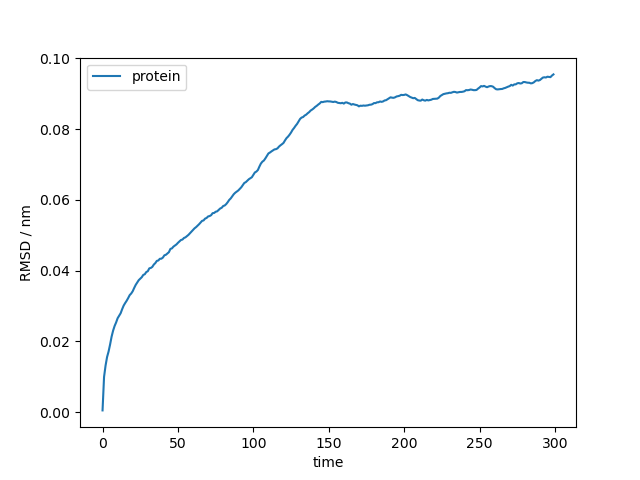

In [15]:
# make sure rmsd plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_195050'))

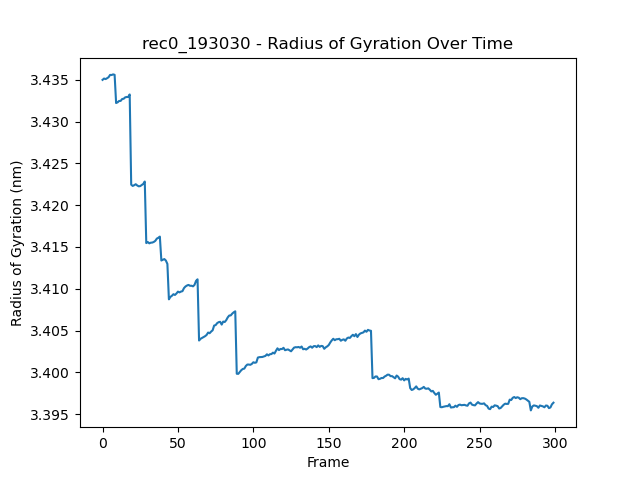

In [14]:
# make sure rgy plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_195046'))

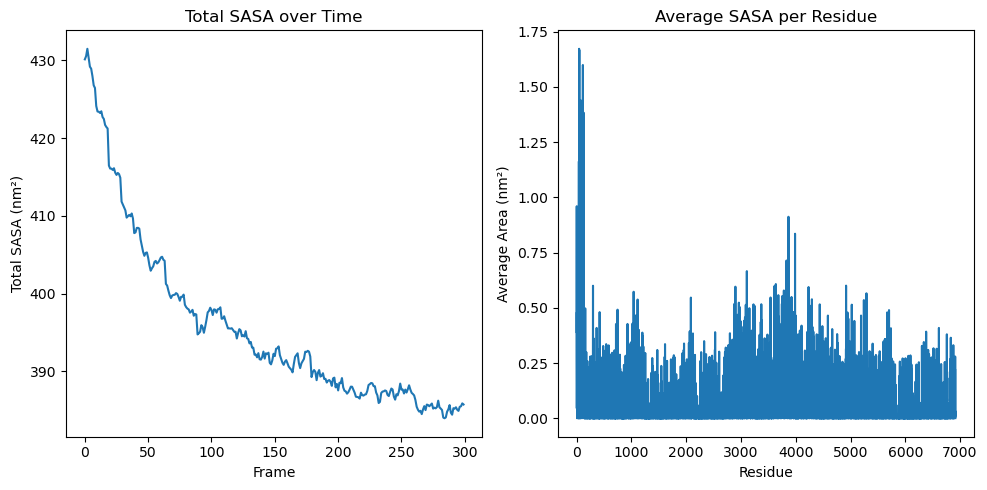

In [13]:
# make sure sasa plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_195042'))

In [12]:
# make sure trajectory and topology exist (sim1)
traj_path_2_2 = registry_2.get_mapped_path("rec0_193631")
top_path_2_2 = registry_2.get_mapped_path("top_sim0_193626")

assert os.path.exists(traj_path_2_2)
assert os.path.exists(top_path_2_2)

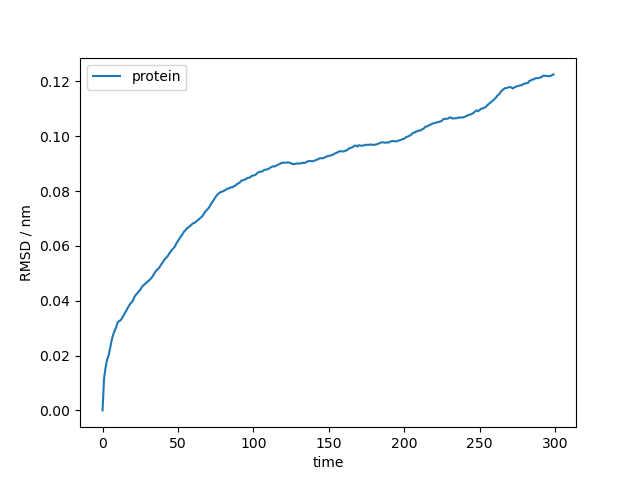

In [11]:
# make sure rmsd plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_195053'))